In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=098ab74550cd7e342aa65a41cdc7c4b719374b0b26c2fbdcd8e7060f91a87133
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
pip install pydicom

     |████████████████████████████████| 1.9MB 4.2MB/s 


In [ ]:
pip install albumentations

     |████████████████████████████████| 634kB 4.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=0f374f77007dd70d48239f7524cc754dd9e22774b9af3c5090c2180f44daae96
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
pip install torchcam

In [ ]:
from torchcam.cams import SmoothGradCAMpp
import time
import csv
import os
import copy
import re
import shutil
import pydicom
import pytesseract
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import albumentations as A
from albumentations.pytorch import ToTensor
from scipy import interp

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform         
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx,0]
    data = pydicom.dcmread(img_name) # read dicom file
    arr = data.pixel_array # read image into pixel data
    shape = arr.shape
    if len(shape) == 4:
      arr = arr[0,:,:,0] # get the first slide of image
    elif len(shape) == 3:
      arr = arr[:,:,0] # get the first slide of image
    else:
      arr = arr
    image = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)

    labels = np.array(self.df.drop(['image_name'],axis=1))
    label = labels[idx]

    if self.transform:
      image = self.transform(image=image)["image"]
    
    return image, label

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Data_testing/file_names.csv")

means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)

albumentation_train_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                      A.RandomCrop(height=224, width=224),
                                      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                                      A.RandomBrightnessContrast(p=0.5),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                    ])
albumentation_val_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.CenterCrop(height=224, width=224),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                  ])

(train_df, val_df) = train_test_split(df, test_size = 0.4)
(val_df, test_df) = train_test_split(val_df, test_size = 0.5)

train_dataset = ImageDataset(train_df, transform=albumentation_train_transform)
val_dataset = ImageDataset(val_df, transform=albumentation_val_transform)
test_dataset = ImageDataset(test_df, transform=albumentation_val_transform)

batch_num = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
class MultiLabelResnet(nn.Module):
  def __init__(self):
    super(MultiLabelResnet, self).__init__()
    self.resnet = models.resnet18(pretrained=True) 
    self.linear = nn.Linear(1000, 4)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.resnet(x)
    x = self.relu(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    
    return x

In [ ]:
def calculate_metric(pred, label):
  return {
      "micro_f1":f1_score(y_true=label, y_pred=pred, average='micro'),
      "macro_f1":f1_score(y_true=label, y_pred=pred, average='macro'),
  }

In [ ]:
def train_model(train_dataloader, val_dataloader, optimizer, criterion, net, threshold, num_epochs):
  since = time.time()

  tot_train_loss = []
  tot_val_loss = []

  tot_train_acc = []
  tot_val_acc = []
  
  for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch+1, num_epochs-1))
    print('-' * 10)

    net.train()
    
    train_running_loss = 0.0
    train_loss_values = []

    train_outputs = []
    train_labels = []

    for idx, data in enumerate(train_dataloader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      outputs = net(img)
      loss = criterion(outputs, label.type(torch.float))

      pred = outputs.data > threshold
      pred = pred.type(torch.float)

      loss.backward()
      optimizer.step()
      
      train_loss_values.append(loss.item())
      train_running_loss += loss.item()

      train_outputs.extend(pred.cpu().to(torch.int).numpy())
      train_labels.extend(label.cpu().to(torch.int).numpy())

    train_result = calculate_metric(np.array(train_outputs), np.array(train_labels))

    net.eval()

    validation_running_loss = 0.0
    val_loss_values = []

    with torch.no_grad():
      val_outputs = []
      val_labels = []
      for val_idx, val_data in enumerate(val_dataloader):
        val_img, val_label = val_data
        val_img = val_img.to(device) 
        val_label = val_label.to(device)

        val_output = net(val_img)

        val_loss = criterion(val_output, val_label.type(torch.float))

        val_pred = val_output.data > threshold
        val_pred = val_pred.type(torch.float)

        val_outputs.extend(val_pred.cpu().to(torch.int).numpy())
        val_labels.extend(val_label.cpu().to(torch.int).numpy())

        val_loss_values.append(val_loss.item())
        validation_running_loss += val_loss.item()

    val_result = calculate_metric(np.array(val_outputs), np.array(val_labels))

    final_train_loss = train_running_loss/len(train_dataloader)
    final_val_loss = validation_running_loss/len(val_dataloader)

    tot_train_loss.append(final_train_loss)
    tot_val_loss.append(final_val_loss)

    tot_train_acc.append(train_result)
    tot_val_acc.append(val_result)

    print("train loss: {}".format(final_train_loss))
    print("validation loss: {}".format(final_val_loss))
    print("train accuracy:\n",train_result)
    print("validation accuracy:\n",val_result)
    print()

  tot_time = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(tot_time // 60, tot_time % 60))

  return net, tot_train_loss, tot_val_loss, tot_train_acc, tot_val_acc 

In [ ]:
network = MultiLabelResnet()
network = network.to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.00001)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
train_ft, resnet_train_loss, resnet_val_loss, resnet_train_result, resnet_val_result = train_model(train_dataloader, val_dataloader, optimizer, criterion, network, 0.5, 41)

Epoch: 1/40
----------
train loss: 0.663768049917723
validation loss: 0.6126891660690308
train accuracy:
 {'micro_f1': 0.4772596430627518, 'macro_f1': 0.4036281810009411}
validation accuracy:
 {'micro_f1': 0.5635555555555556, 'macro_f1': 0.3282054737556693}

Epoch: 2/40
----------
train loss: 0.5492976527465018
validation loss: 0.5054426252841949
train accuracy:
 {'micro_f1': 0.6773360867320598, 'macro_f1': 0.5869173622123367}
validation accuracy:
 {'micro_f1': 0.6852830188679245, 'macro_f1': 0.5467707185025086}

Epoch: 3/40
----------
train loss: 0.4676147997379303
validation loss: 0.4368316972255707
train accuracy:
 {'micro_f1': 0.7697577685343773, 'macro_f1': 0.7185169960190154}
validation accuracy:
 {'micro_f1': 0.7587209302325582, 'macro_f1': 0.6913362879504557}

Epoch: 4/40
----------
train loss: 0.41498548890414994
validation loss: 0.3848222005367279
train accuracy:
 {'micro_f1': 0.8021416403017765, 'macro_f1': 0.7651141545396477}
validation accuracy:
 {'micro_f1': 0.79912344777

In [ ]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.cams import SmoothGradCAMpp, XGradCAM
import random

In [ ]:
test_dataloader = DataLoader(test_dataset)

albumentation_val_transform2 = A.Compose([
                                      A.Resize(256,256),
                                      A.CenterCrop(height=224, width=224),
                                      ToTensor(),
                                  ])
test_dataset2 = ImageDataset(test_df, transform=albumentation_val_transform2)
test_dataloader2 = DataLoader(test_dataset2)


tensor([[0, 1, 1, 0]])


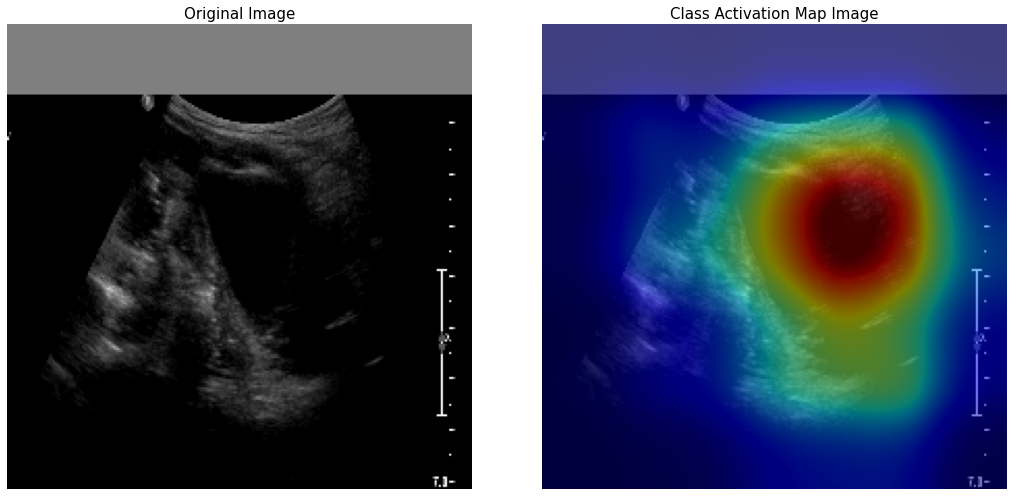


tensor([[1, 0, 0, 0]])


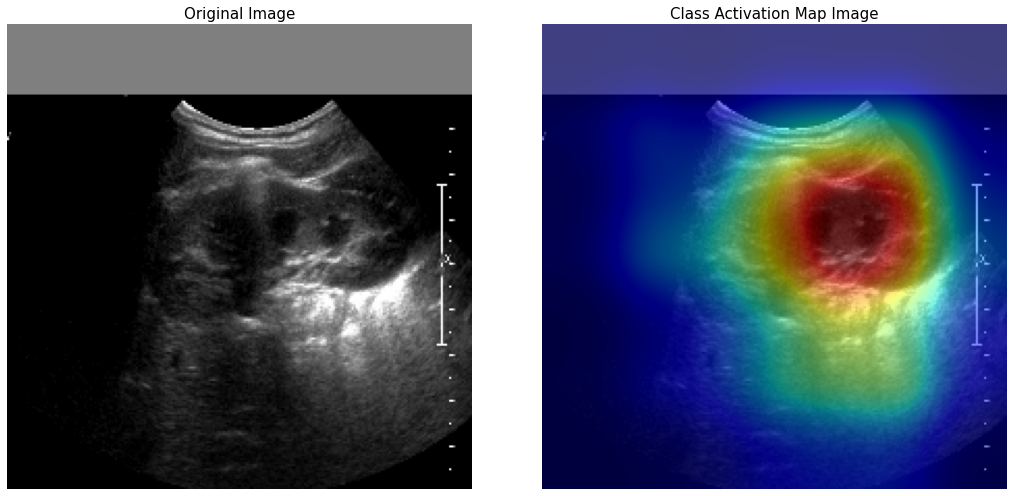


tensor([[1, 0, 0, 0]])


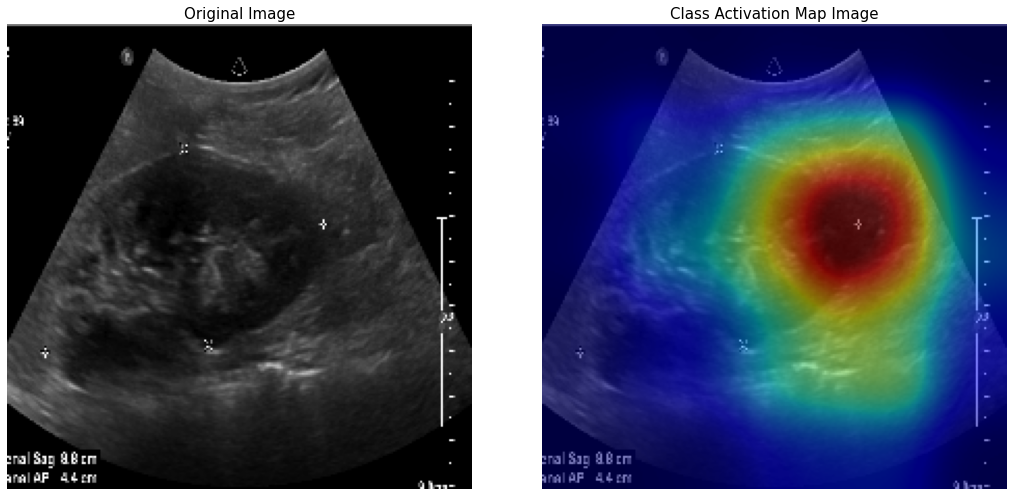

In [ ]:
l = []
for i in range(3):
  ranint = random.randint(1,30)
  l.append(ranint)


it = iter(test_dataloader)
it2 = iter(test_dataloader2)
idx = 0
for i in range(30):
  img,label = next(it)
  img2,label2 = next(it2)
  idx += 1
  if idx in l:
    model = train_ft.eval().to(device)
    cam_extractor = XGradCAM(model)
    result = overlay_mask(to_pil_image(np.squeeze(img2)), to_pil_image(activation_map, mode='F'), alpha=0.5)
    print()
    print(label)
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.imshow(to_pil_image(np.squeeze(img2)))
    plt.axis('off')
    plt.title("Original Image", fontsize=20)
    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.axis('off')
    plt.title("Class Activation Map Image",fontsize=20)
    plt.tight_layout() 
    plt.show()

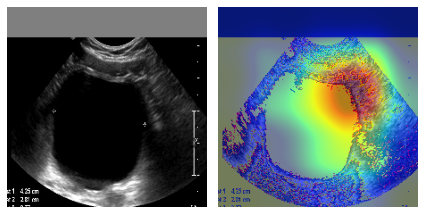

In [ ]:
"img,label = next(it)
img2,label2 = next(it2)

result = overlay_mask(to_pil_image(np.squeeze(img)), to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.subplot(1,2,1)
plt.imshow(to_pil_image(np.squeeze(img2)))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result)
plt.axis('off')
plt.tight_layout() 
plt.show()

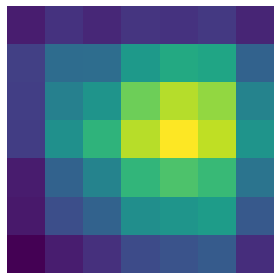

In [ ]:
plt.imshow(activation_map.cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
albumentation_val_transform2 = A.Compose([
                                      A.Resize(256,256),
                                      A.CenterCrop(height=224, width=224),
                                      ToTensor(),
                                  ])
test_dataset2 = ImageDataset(test_df, transform=albumentation_val_transform2)
test_dataloader2 = DataLoader(test_dataset2)

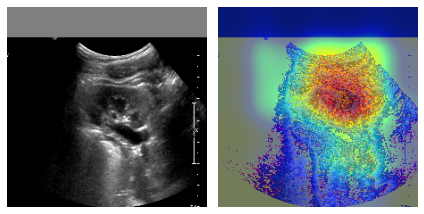

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

result = overlay_mask(to_pil_image(np.squeeze(img)), to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.subplot(1,2,1)
plt.imshow(to_pil_image(np.squeeze(img2)))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result)
plt.axis('off')
plt.tight_layout() 
plt.show()

In [ ]:
it = iter(test_dataloader)
img,label = next(it)
second = next(it)
print(img)
print(second)

tensor([[[[ 0.0569,  0.0569,  0.0569,  ...,  0.0569,  0.0569,  0.0569],
          [ 0.0569,  0.0569,  0.0569,  ...,  0.0569,  0.0569,  0.0569],
          [ 0.0569,  0.0569,  0.0569,  ...,  0.0569,  0.0569,  0.0569],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 0.1877,  0.1877,  0.1877,  ...,  0.1877,  0.1877,  0.1877],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.1877,  0.1877,  0.1877],
          [ 0.1877,  0.1877,  0.1877,  ...,  0.1877,  0.1877,  0.1877],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 0.4091,  0.4091,  0.4091,  ...,  0.4091,  0.4091,  0.4091],
          [ 0.4091,  0.4091,  

In [ ]:
for i in range(3):  
  data = iter(test_dataloader)
  print(data)